In [1]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Pytorch+cpp integration code implimentation notebook. 

lets say we don't want to use the conventional LSTM model for our specific usecase and make a modified LSTM model.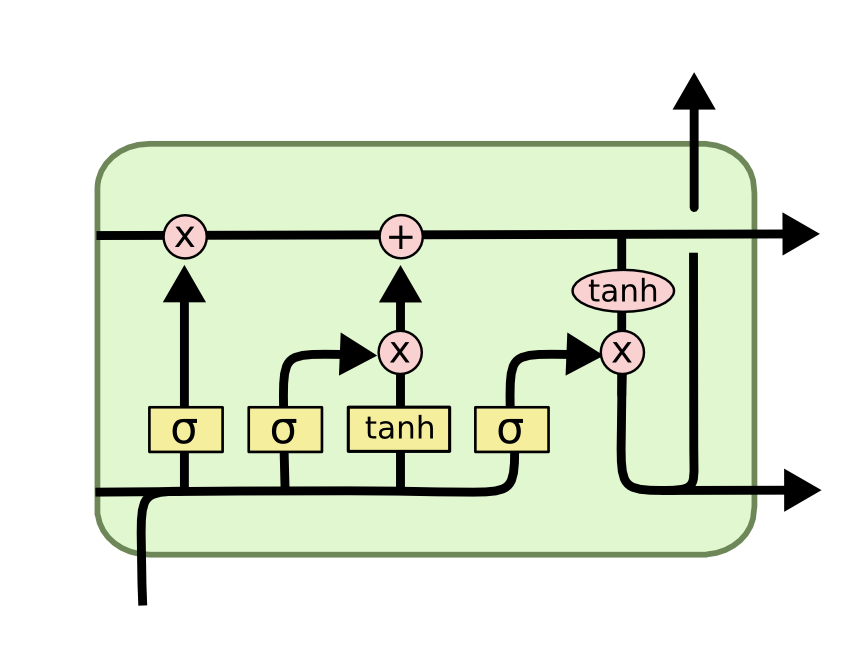

Instead of conventional LSTM , I want to change the tanh function to ELU function . 

This can be done in 2 ways , 
*   by using pytoch nn.module  to create an custom module and lets name it LLTM. 
*   We can also write it in cpp code and then build and bind it with python code using pybind .



##Approach 1: using pytorch nn.module

In [2]:
import torch
import torch.nn.functional as F

class LLTM(torch.nn.Module):
    def __init__(self, input_features, state_size):
        super(LLTM, self).__init__()
        self.input_features = input_features
        self.state_size = state_size
        # 3 * state_size for input gate, output gate and candidate cell gate.
        # input_features + state_size because we will multiply with [input, h].
        self.weights = torch.nn.Parameter(torch.empty(3 * state_size, input_features + state_size))
        self.bias = torch.nn.Parameter(torch.empty(3 * state_size))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.state_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, +stdv)

    def forward(self, input, state):
        old_h, old_cell = state
        X = torch.cat([old_h, input], dim=1)

        # Compute the input, output and candidate cell gates with one MM.
        gate_weights = F.linear(X, self.weights, self.bias)
        # Split the combined gate weight matrix into its components.
        gates = gate_weights.chunk(3, dim=1)

        input_gate = torch.sigmoid(gates[0])
        output_gate = torch.sigmoid(gates[1])
        # Here we use an ELU instead of the usual tanh.
        candidate_cell = F.elu(gates[2])

        # Compute the new cell state.
        new_cell = old_cell + candidate_cell * input_gate
        # Compute the new hidden state and output.
        new_h = torch.tanh(new_cell) * output_gate

        return new_h, new_cell

In [3]:
import time
import math
import torch

batch_size = 16
input_features = 32
state_size = 128

X = torch.randn(batch_size, input_features)
h = torch.randn(batch_size, state_size)
C = torch.randn(batch_size, state_size)

rnn = LLTM(input_features, state_size)

forward = 0
backward = 0
for _ in range(100000):
    start = time.time()
    new_h, new_C = rnn(X, (h, C))
    forward += time.time() - start

    start = time.time()
    (new_h.sum() + new_C.sum()).backward()
    backward += time.time() - start

print('Forward: {:.3f} s | Backward {:.3f} s'.format(forward, backward))

Forward: 19.326 s | Backward 26.193 s


##Approach 2 : using cpp file to write the code and then build and combile with pytorch using pybind 

In [4]:
%%writefile setup.py

from setuptools import setup
from torch.utils.cpp_extension import BuildExtension, CppExtension

setup(
    name='lltm',
    ext_modules=[
        CppExtension(name = 'lltm', sources = ['lltm.cpp'],extra_compile_args=['-g']),
    ],
    cmdclass={
        'build_ext': BuildExtension
    })

Writing setup.py


In [5]:
%%writefile lltm.cpp

// torch/extension.h is used to extend the pytorch functinality using cpp .
// also  it comes with existing torch functions which we can use readymadely

//<torch/extension.h> is the one-stop header to include all the necessary PyTorch bits to write C++ extensions. It includes:
//The ATen library, which is our primary API for tensor computation,
//pybind11, which is how we create Python bindings for our C++ code,
//Headers that manage the details of interaction between ATen and pybind11.

#include <torch/extension.h>

#include <iostream>
#include <vector>


torch::Tensor d_sigmoid(torch::Tensor z) {
  auto s = torch::sigmoid(z);
  return (1 - s) * s;
}



std::vector<at::Tensor> lltm_forward(
    torch::Tensor input,
    torch::Tensor weights,
    torch::Tensor bias,
    torch::Tensor old_h,
    torch::Tensor old_cell) {
  auto X = torch::cat({old_h, input}, /*dim=*/1);

  auto gate_weights = torch::addmm(bias, X, weights.transpose(0, 1));
  auto gates = gate_weights.chunk(3, /*dim=*/1);

  auto input_gate = torch::sigmoid(gates[0]);
  auto output_gate = torch::sigmoid(gates[1]);
  auto candidate_cell = torch::elu(gates[2], /*alpha=*/1.0);  // the Elu implimentation instead of tanh 

  auto new_cell = old_cell + candidate_cell * input_gate;
  auto new_h = torch::tanh(new_cell) * output_gate;

  return {new_h,
          new_cell,
          input_gate,
          output_gate,
          candidate_cell,
          X,
          gate_weights};
}

// we also need the derivative function for tanh as in output gate we are not changeing the tanh function 
// tanh'(z) = 1 - tanh^2(z)
torch::Tensor d_tanh(torch::Tensor z) {
  return 1 - z.tanh().pow(2);
}

// derivative of elu is required for back propagation and weight update at elu cell 
// elu'(z) = relu'(z) + { alpha * exp(z) if (alpha * (exp(z) - 1)) < 0, else 0}
torch::Tensor d_elu(torch::Tensor z, torch::Scalar alpha = 1.0) {
  auto e = z.exp();
  auto mask = (alpha * (e - 1)) < 0;
  return (z > 0).type_as(z) + mask.type_as(z) * (alpha * e);
}


// In pytorch there is no need to writting the backward pass for any module as it takes care of back propagation internally 
// in a very optimised way . but in cpp we dont have that provision.
// hence have to calculate all the derivative and explicitly write code to perform back propagation

std::vector<torch::Tensor> lltm_backward(
    torch::Tensor grad_h,
    torch::Tensor grad_cell,
    torch::Tensor new_cell,
    torch::Tensor input_gate,
    torch::Tensor output_gate,
    torch::Tensor candidate_cell,
    torch::Tensor X,
    torch::Tensor gate_weights,
    torch::Tensor weights) {

  // the last layer output is the derivative of the whole module

  auto d_output_gate = torch::tanh(new_cell) * grad_h;        
  auto d_tanh_new_cell = output_gate * grad_h;               
  auto d_new_cell = d_tanh(new_cell) * d_tanh_new_cell + grad_cell;

  // assign current layer derivative to previous layer 
  auto d_old_cell = d_new_cell;
  auto d_candidate_cell = input_gate * d_new_cell;
  auto d_input_gate = candidate_cell * d_new_cell;

  // follow the chain rule  to get the derivative accross the network . 
  auto gates = gate_weights.chunk(3, /*dim=*/1);
  d_input_gate *= d_sigmoid(gates[0]);
  d_output_gate *= d_sigmoid(gates[1]);
  d_candidate_cell *= d_elu(gates[2]);

  auto d_gates =
      torch::cat({d_input_gate, d_output_gate, d_candidate_cell}, /*dim=*/1);

  auto d_weights = d_gates.t().mm(X);
  auto d_bias = d_gates.sum(/*dim=*/0, /*keepdim=*/true);

  auto d_X = d_gates.mm(weights);
  const auto state_size = grad_h.size(1);
  auto d_old_h = d_X.slice(/*dim=*/1, 0, state_size);
  auto d_input = d_X.slice(/*dim=*/1, state_size);

  return {d_old_h, d_input, d_weights, d_bias, d_old_cell};
}


PYBIND11_MODULE(TORCH_EXTENSION_NAME, m) {
  m.def("forward", &lltm_forward, "LLTM forward");
  m.def("backward", &lltm_backward, "LLTM backward");
}

Writing lltm.cpp


In [6]:
!python setup.py install

running install
running bdist_egg
running egg_info
creating lltm.egg-info
writing lltm.egg-info/PKG-INFO
writing dependency_links to lltm.egg-info/dependency_links.txt
writing top-level names to lltm.egg-info/top_level.txt
writing manifest file 'lltm.egg-info/SOURCES.txt'
/usr/local/lib/python3.8/dist-packages/torch/utils/cpp_extension.py:476: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
reading manifest file 'lltm.egg-info/SOURCES.txt'
writing manifest file 'lltm.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_ext
building 'lltm' extension
creating build
creating build/temp.linux-x86_64-3.8
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -g -fwrapv -O2 -g -fstack

In [7]:
# append the recently build path to sys.path
import sys
sys.path.append('/usr/local/lib/python3.8/dist-packages/lltm-0.0.0-py3.8-linux-x86_64.egg')
sys.path.append('/content/build')
sys.path.append('/content/dist')
sys.path.append('/content/lltm.egg.info')
sys.path.append('/content')
sys.path.append('/bin')
sys.path.append('/lib')
sys.path.append('/tmp')
sys.path.append('/usr')


To make the newly build function act like same as other torch autograd function the LLTM pybind needs to be wrapped in torch autograd. so that we dont need to call backpropagation explicitly while using the LLTM function. 

Also create the LLTM module in pytorch. 

In [8]:

import math
import torch

import lltm

#  add LLTM functionality to autograd by defining forward and backward pass 
class LLTMFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, weights, bias, old_h, old_cell):
        outputs = lltm.forward(input, weights, bias, old_h, old_cell)
        new_h, new_cell = outputs[:2]
        variables = outputs[1:] + [weights]
        ctx.save_for_backward(*variables)

        return new_h, new_cell

    @staticmethod
    def backward(ctx, grad_h, grad_cell):
        outputs = lltm.backward(
            grad_h.contiguous(), grad_cell.contiguous(), *ctx.saved_tensors)
        d_old_h, d_input, d_weights, d_bias, d_old_cell = outputs
        return d_input, d_weights, d_bias, d_old_h, d_old_cell

#  create LLTM module 
class LLTM(torch.nn.Module):
    def __init__(self, input_features, state_size):
        super(LLTM, self).__init__()
        self.input_features = input_features
        self.state_size = state_size
        self.weights = torch.nn.Parameter(
            torch.empty(3 * state_size, input_features + state_size))
        self.bias = torch.nn.Parameter(torch.empty(3 * state_size))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.state_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, +stdv)

    def forward(self, input, state):
        return LLTMFunction.apply(input, self.weights, self.bias, *state)

In [9]:
import time

import torch

batch_size = 16
input_features = 32
state_size = 128

X = torch.randn(batch_size, input_features)
h = torch.randn(batch_size, state_size)
C = torch.randn(batch_size, state_size)

rnn = LLTM(input_features, state_size) #  LLTM module from torch (cpp build )

forward = 0
backward = 0
for _ in range(100000):
    start = time.time()
    new_h, new_C = rnn(X, (h, C))
    forward += time.time() - start

    start = time.time()
    (new_h.sum() + new_C.sum()).backward()
    backward += time.time() - start

print('Forward: {:.3f} s | Backward {:.3f} s'.format(forward, backward))

Forward: 15.451 s | Backward 38.248 s


we can clearly see the improvement in execution time by using the cpp for LLTM execution as in general cpp works much faster than that of python code. 